In [1]:
import warnings
warnings.filterwarnings('ignore')
import dvc.api
import mlflow
import sys
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import importlib
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from datetime import datetime
import joblib

In [18]:
import sys
sys.path.append("..")

from myscripts import modelprep
from myscripts import preprocess_data


In [3]:
def load_data_dvc(path, git_revision):

    repo = 'https://github.com/fbagire/sales_predict'
    version = git_revision

    data_url = dvc.api.get_url(path=path, repo=repo, rev=version)

    mlflow.set_experiment('sales_predict')

    if __name__ == '__main__':
        warnings.filterwarnings('ignore')
        np.random.seed(40)
        with mlflow.start_run(nested=True) as mlrun:
            data = pd.read_csv(data_url, index_col=[0])

    return data

In [5]:
# git_rev
vf = '70a72e7e4cda6da4ab57bb8571e5cc2f3c5366e0'

train_df = load_data_dvc('data/train_model.csv', vf)

test_df = load_data_dvc('data/test_model.csv', vf)

train_df.shape, test_df.shape

((1017209, 19), (41088, 17))

In [37]:
importlib.reload(modelprep)
importlib.reload(preprocess_data)

<module 'myscripts.preprocess_data' from '..\\myscripts\\preprocess_data.py'>

In [42]:
model_prep = modelprep.Modeller(train_df)

In [43]:
X_train, X_val, y_train, y_val = model_prep.split_data()

In [8]:
def fetch_logged_data(run_id):
    client = mlflow.tracking.MlflowClient()
    data = client.get_run(run_id).data
    tags = {k: v for k, v in data.tags.items() if not k.startswith("mlflow.")}
    artifacts = [f.path for f in client.list_artifacts(run_id, "model")]
    return data.params, data.metrics, tags, artifacts

In [9]:
estimators = 25
depth = 15
pipeline = Pipeline([('scaler', StandardScaler()),
                     ('rf_regressor',
                      RandomForestRegressor(n_estimators=estimators,
                                            max_depth=depth,
                                            min_samples_split=2,
                                            min_samples_leaf=1))])

In [10]:
val='validation_'

In [11]:
mlflow.set_experiment('sales_predict')
mlflow.sklearn.autolog()

with mlflow.start_run() as run:

    rf_model = pipeline.fit(X_train, y_train)
    y_pred = rf_model.predict(X_val)
    mse, rmse, r2 = model_prep.error_calculate(y_val, y_pred)
    mlflow.log_metrics({val + "mse": mse, val + 'rmse': rmse, val + 'r2': r2},step=1)
    mlflow.sklearn.log_model(rf_model, "Regressor model")

In [12]:
params, metrics, tags, artifacts = fetch_logged_data(run.info.run_id)

In [13]:
#Model serializing and saving
#creating a file name using the now timestamp
mdl_tmp = '../models/' + str(
    datetime.now().strftime("%d-%m-%Y-%H-%M-%S")) + '.pkl'
joblib.dump(rf_model, mdl_tmp)

['../models/05-08-2022-13-48-27.pkl']

**Feature Importance**

Displayin top 10

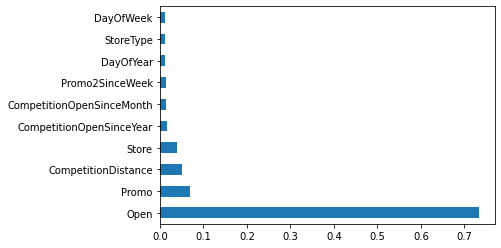

In [44]:
model_prep.feature_importance(pipeline.steps[1][1],x_train=X_train)

## Deep Learning

In [4]:
# Create a timeseries of timeseries Sales
from matplotlib.gridspec import GridSpec
from matplotlib import ticker
from statsmodels.tsa.stattools import adfuller, acf, pacf
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [5]:
# load original data
git_rev="214d629a7f3ab08d36c1abb773b0fecf2d78a6c3"

In [6]:
train_og=load_data_dvc('data/train.csv',git_revision=git_rev)

In [7]:
train_og['Date']=pd.to_datetime(train_og['Date'])

In [80]:
sales_ts=train_og[['Date','Sales']]

In [81]:
# To make a timeseries we can group the data we have by their frequency which is daily 
sales_ts=sales_ts.groupby(by='Date').mean()

In [82]:
import seaborn as sns
from matplotlib.gridspec import GridSpec
from statsmodels.tsa.stattools import adfuller, acf, pacf

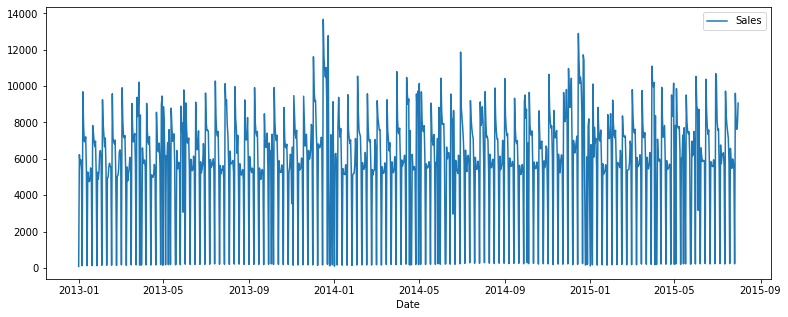

In [83]:
plt.figure(figsize=(13,5))
_=sns.lineplot(data=sales_ts)

From the figure, visually we can see that the timseries has no trend but has probably some seasonality effect. We shall validate this using statistical model

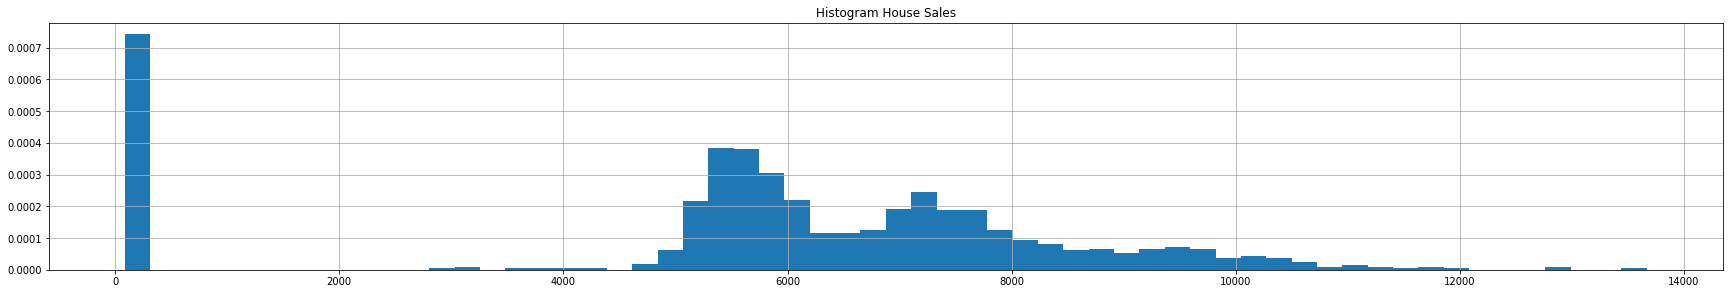

In [84]:
fig = plt.figure()
gs = GridSpec(2, 1, figure=fig)

fig.set_figheight(10)
fig.set_figwidth(30)
fig.tight_layout(pad=6)

ax1 = fig.add_subplot(gs[0,0])
ax1.hist(sales_ts.Sales, density=True, bins=60)
ax1.title.set_text('Histogram House Sales')
ax1.grid(True)

In [85]:
prep=preprocess_data.clean_data(sales_ts)

In [86]:
sales_ts=prep.fix_outliers(sales_ts,['Sales'])

### Stationarity

A stationary time series is one whose properties do not depend on the time at which the series is observed. 14. Thus, time series with trends, or with seasonality, are not stationary — the trend and seasonality will affect the value of the time series at different times.


### Augmented Dickey-Fuller unit root test.

In probability theory and statistics, a unit root is a feature of some stochastic processes (such as random walks) that can cause problems in statistical inference involving time series models. A linear stochastic process has a unit root if 1 is a root of the process's characteristic equation.

One way to determine more objectively whether differencing is required is to use a unit root test.

p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary. p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

In [87]:
adfResult = adfuller(sales_tsDif, autolag='AIC')
print(f'ADF Statistic: {adfResult[0]}')
print(f'p-value: {adfResult[1]}')

ADF Statistic: -5.736861725210556
p-value: 6.408465920482123e-07


As p-value is smaller than 0.05 we reject the null hypothesis (H0) and the data does not have a unit root and is stationary.
if a distribution had been non-stationary we would need to further process the timeseries as it is usually tough to model non-stationary data.

### Removing Stationarity (Trend or Seasonality)
The trend can be removed from the observations, then added back to forecasts later to return the prediction to the original scale and calculate a comparable error score.

A standard way to remove a trend is by differencing the data. That is the observation from the previous time step (t-1) is subtracted from the current observation (t). This removes the trend and we are left with a difference series, or the changes to the observations from one time step to the next.

In [76]:
# create a differenced series
def difference(dataset, interval=120):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)

In [77]:
sales_tsDif = difference(sales_ts.Sales.values)

#### Autocorrelations and Partial Autocorrelations Plots.
We can calculate the correlation for time series observations with observations with previous time steps, called lags. Because the correlation of the time series observations is calculated with values of the same series at previous times, this is called a serial correlation, or an autocorrelation.

In [94]:
acfsales = acf(sales_ts.Sales.values, fft=True, nlags=30)
acfsalesNp = np.array(acfsales)

In [95]:
def corrPlots(array: np.array, prefix: str):
    plt.figure(figsize=(30, 5))
    plt.title(f"{prefix}  Autocorrelations of Sales")
    plt.bar(range(len(array)), array)
    plt.grid(True)
    plt.show()

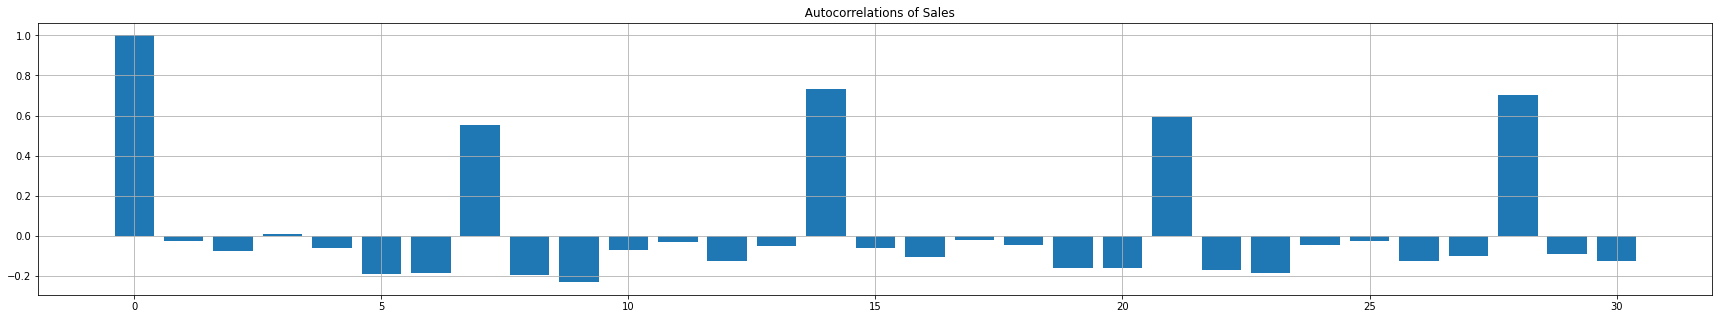

In [96]:
corrPlots(acfsalesNp,'')

A partial autocorrelation is a summary of the relationship between an observation in a time series with observations at prior time steps with the relationships of intervening observations removed

In [98]:
pacfsales = pacf(sales_ts.Sales.values, nlags=30)
pacfsalesNp = np.array(acfsales)

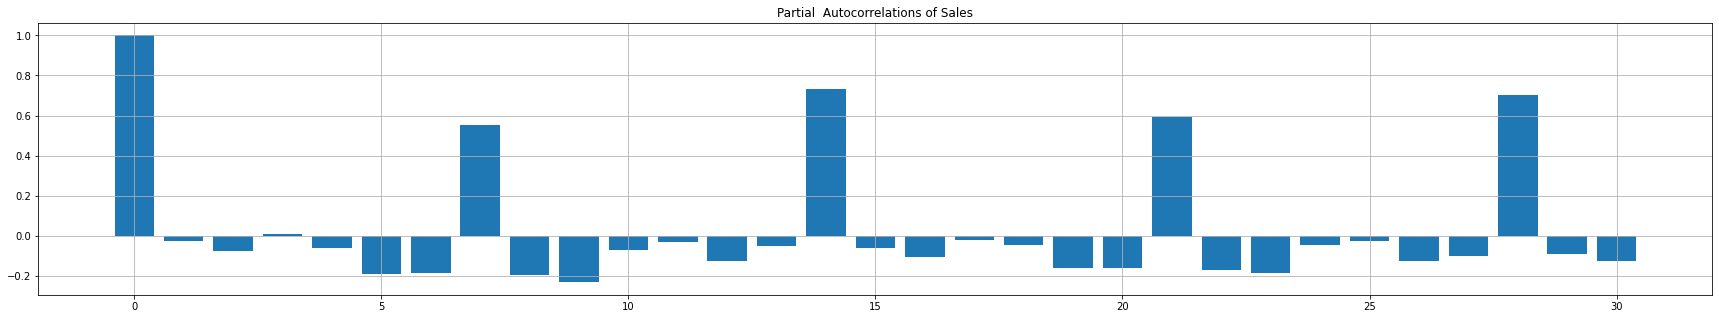

In [99]:
corrPlots(pacfsalesNp, "Partial")